In [1]:
import sys
from pathlib import Path
import pandas as pd
import mdtraj as md
from natsort import natsorted
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from MSMEstimation import MSMEstimation
from TrajData import TrajData
from MSMStudy import MSMStudy
from funcs_featurise import *
from funcs_db_assign import *

### Picking representative A-loop crystal structures

(For abl) How many A-loop conformation clusters can we find in crystal sturcturs?

In [3]:
protein = 'abl'
save_dir = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data/{protein}/plots')
sample_dir = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data/{protein}/samples')
data_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data') # base dir
key = 'abl-pdb-50ps'

TD = TrajData(protein = protein)
TD.add_dataset(rtraj_dir = Path(f'/arc/abl_processed/'), 
               ftraj_dir= data_path / f'{protein}'/ f'{key}' / 'ftrajs',
               dt=0.05,
               key=key)

Setting dataset <abl-pdb-50ps>. 
Number of raw trajectories: 749



In [4]:
crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").glob("kinoml*.pdb")])

frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

In [ ]:
dist = dbdist_featuriser(crystals, protein=protein)
dihed = dbdihed_featuriser(crystals, protein=protein)
spatial_group, dihed_group = dfg_featuriser(traj = crystals, protein = protein)
aloopdist = aloop_featuriser(crystals, protein=protein)

In [ ]:
BLAminus_c_aloopdist = aloopdist[list(np.where(dihed_group == 0)[0]),:] # DFG-in active
BBAminus_c_aloopdist = aloopdist[list(np.where(dihed_group == 7)[0]),:] # DFG-out
print(BLAminus_c_aloopdist.shape, BBAminus_c_aloopdist.shape)

(14, 210) (39, 210)


In [9]:
pca = PCA(n_components=5)
pca.fit(np.concatenate([BLAminus_c_aloopdist, BBAminus_c_aloopdist], axis=0))

PCA(n_components=5)

In [10]:
BLAminus_transformed = pca.transform(BLAminus_c_aloopdist)
BBAminus_transformed = pca.transform(BBAminus_c_aloopdist)

/tmp/ipykernel_25352/4023575233.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(BLAminus_transformed[:,0], BLAminus_transformed[:,1], c=(235/255, 95/255, 70/255), label='BLAminus')
/tmp/ipykernel_25352/4023575233.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(BBAminus_transformed[:,0], BBAminus_transformed[:,1], c=(136/255, 75/255, 204/255), label='BBAminus')


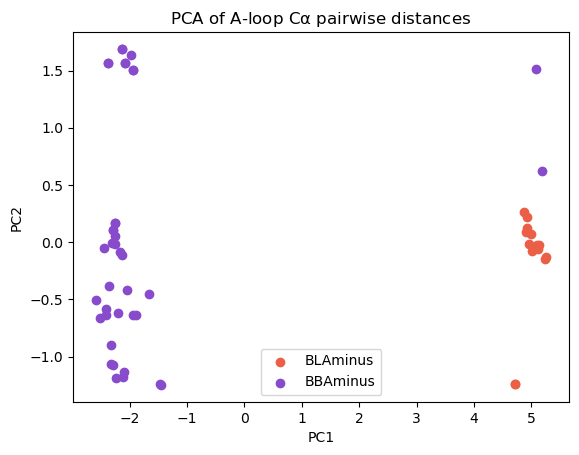

In [ ]:
# This plot shows the DFG-in and DFG-out A-loop conformations on the PCA space

fig, ax = plt.subplots()
ax.scatter(BLAminus_transformed[:,0], BLAminus_transformed[:,1], c=(235/255, 95/255, 70/255), label='BLAminus')
ax.scatter(BBAminus_transformed[:,0], BBAminus_transformed[:,1], c=(136/255, 75/255, 204/255), label='BBAminus')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title(r'PCA of A-loop C$\mathrm{\alpha}$ pairwise distances')
ax.legend()

plt.savefig(save_dir / 'crystal_aloop_pca.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [12]:
kmeans_mod = KMeans(n_clusters=7)
kmeans_mod.fit(np.concatenate([BLAminus_transformed, BBAminus_transformed], axis=0))

/home/rzhu/Loc/miniconda3/envs/msm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7)

In [13]:
BLAminus_clustered = kmeans_mod.predict(BLAminus_transformed)
BBAminus_clustered = kmeans_mod.predict(BBAminus_transformed)

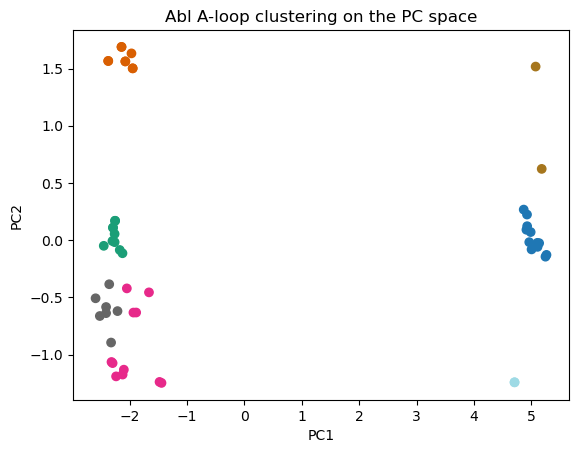

In [14]:
fig, ax = plt.subplots()
ax.scatter(BLAminus_transformed[:,0], BLAminus_transformed[:,1], c=BLAminus_clustered, cmap='tab20')
ax.scatter(BBAminus_transformed[:,0], BBAminus_transformed[:,1], c=BBAminus_clustered, cmap='Dark2')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title(rf'Abl A-loop clustering on the PC space')

plt.savefig(save_dir / 'crystal_aloop_kmeans.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

---

Plot the RMSD of a-loop conformations of crystal structures

In [ ]:
rmsd_matrix = np.zeros((len(crystals), len(crystals)))
indices = get_feature_indices(crystals.topology, 'abl', 'aloop')

for i in range(len(crystals)):
    rmsd_matrix[i,:] = md.rmsd(crystals, crystals, i, 
                               atom_indices=crystals.topology.select(f'resid {indices["aloop_start"]} to {indices["aloop_end"]}'))

In [ ]:
# Group the RMSD of the same k-means cluster together

group_idx = kmeans_mod.predict(pca.transform(aloopdist))
sorted_indices = np.argsort(group_idx)
rmsd_grouped = rmsd_matrix[np.ix_(sorted_indices, sorted_indices)]

In [20]:
np.unique(group_idx, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([12, 10, 12, 14,  3, 24,  8]))

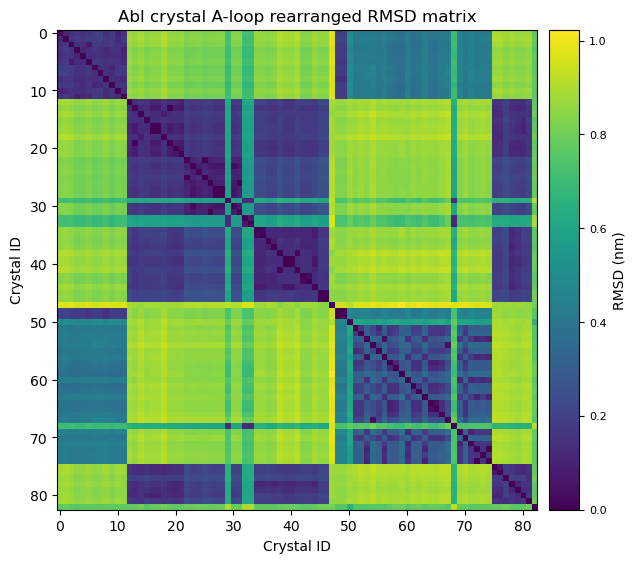

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0, 0, 0.8, 0.8])
cbar_ax = fig.add_axes([0.82, 0, 0.05, 0.8])
im = ax.imshow(rmsd_grouped, cmap='viridis')
plt.colorbar(im, cax=cbar_ax)

ax.set_title(f'Abl crystal A-loop rearranged RMSD matrix')
ax.set_xlabel('Crystal ID')
ax.set_ylabel('Crystal ID')

cbar_ax.set_ylabel('RMSD (nm)')
cbar_ax.tick_params(axis='y', labelsize=8)

plt.savefig(save_dir / f'crystal_rmsd_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
with open(sample_dir / f'crystal_aloop_groups.txt', 'w') as f:
    for id in np.unique(group_idx):
        f.write(f'Group {id}\n')
        for crystal in np.where(group_idx == id)[0]:
            f.write(f'{crystal_files[crystal]}\n')

In [ ]:
# Pick the first crystal structure of each kmeans cluster as reference
references = [md.load(crystal_files[np.where(group_idx == id)[0][0]]) for id in np.unique(group_idx)]

In [27]:
# Calculate A-loop RMSD of simulation data with respect to the references.

for i, ref in enumerate(references):
    feature_name = f'aloop_rmsd_ref{i}'
    TD.featurize(key=key,
                 featurisers=[alooprmsd_featuriser],
                 feature_names=[feature_name],
                 reference=ref)

Featurising protein abl
Featurisers: ['alooprmsd_featuriser']


100%|██████████| 749/749 [00:00<00:00, 16011.98it/s]


Featurising run0-clone0
run0-clone0 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone2
run0-clone2 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone3
run0-clone3 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone4
run0-clone4 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone5
run0-clone5 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone6
run0-clone6 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone7
run0-clone7 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone8
run0-clone8 aloop_rmsd_ref0 ftraj already exist.
Featurising run0-clone9
run0-clone9 aloop_rmsd_ref0 ftraj already exist.
Featurising run1-clone1
run1-clone1 aloop_rmsd_ref0 ftraj already exist.
Featurising run1-clone2
run1-clone2 aloop_rmsd_ref0 ftraj already exist.
Featurising run1-clone4
run1-clone4 aloop_rmsd_ref0 ftraj already exist.
Featurising run1-clone5
run1-clone5 aloop_rmsd_ref0 ftraj already exist.
Featurising run1-clone6
run1-clone6 aloop_rmsd_ref0

100%|██████████| 749/749 [00:00<00:00, 15897.00it/s]


Featurising run0-clone0
run0-clone0 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone2
run0-clone2 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone3
run0-clone3 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone4
run0-clone4 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone5
run0-clone5 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone6
run0-clone6 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone7
run0-clone7 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone8
run0-clone8 aloop_rmsd_ref1 ftraj already exist.
Featurising run0-clone9
run0-clone9 aloop_rmsd_ref1 ftraj already exist.
Featurising run1-clone1
run1-clone1 aloop_rmsd_ref1 ftraj already exist.
Featurising run1-clone2
run1-clone2 aloop_rmsd_ref1 ftraj already exist.
Featurising run1-clone4
run1-clone4 aloop_rmsd_ref1 ftraj already exist.
Featurising run1-clone5
run1-clone5 aloop_rmsd_ref1 ftraj already exist.
Featurising run1-clone6
run1-clone6 aloop_rmsd_ref1

100%|██████████| 749/749 [00:00<00:00, 16548.06it/s]


Featurising run0-clone0
run0-clone0 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone2
run0-clone2 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone3
run0-clone3 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone4
run0-clone4 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone5
run0-clone5 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone6
run0-clone6 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone7
run0-clone7 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone8
run0-clone8 aloop_rmsd_ref2 ftraj already exist.
Featurising run0-clone9
run0-clone9 aloop_rmsd_ref2 ftraj already exist.
Featurising run1-clone1
run1-clone1 aloop_rmsd_ref2 ftraj already exist.
Featurising run1-clone2
run1-clone2 aloop_rmsd_ref2 ftraj already exist.
Featurising run1-clone4
run1-clone4 aloop_rmsd_ref2 ftraj already exist.
Featurising run1-clone5
run1-clone5 aloop_rmsd_ref2 ftraj already exist.
Featurising run1-clone6
run1-clone6 aloop_rmsd_ref2

  0%|          | 0/749 [00:00<?, ?it/s]

Featurising run0-clone0
run0-clone0 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone2
run0-clone2 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone3
run0-clone3 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone4
run0-clone4 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone5
run0-clone5 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone6
run0-clone6 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone7
run0-clone7 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone8
run0-clone8 aloop_rmsd_ref3 ftraj already exist.
Featurising run0-clone9
run0-clone9 aloop_rmsd_ref3 ftraj already exist.
Featurising run1-clone1
run1-clone1 aloop_rmsd_ref3 ftraj already exist.
Featurising run1-clone2
run1-clone2 aloop_rmsd_ref3 ftraj already exist.
Featurising run1-clone4
run1-clone4 aloop_rmsd_ref3 ftraj already exist.
Featurising run1-clone5
run1-clone5 aloop_rmsd_ref3 ftraj already exist.
Featurising run1-clone6
run1-clone6 aloop_rmsd_ref3

100%|██████████| 749/749 [00:00<00:00, 16358.75it/s]

run66-clone3 aloop_rmsd_ref3 ftraj already exist.
Featurising run66-clone4
run66-clone4 aloop_rmsd_ref3 ftraj already exist.
Featurising run66-clone5
run66-clone5 aloop_rmsd_ref3 ftraj already exist.
Featurising run66-clone6
run66-clone6 aloop_rmsd_ref3 ftraj already exist.
Featurising run66-clone7
run66-clone7 aloop_rmsd_ref3 ftraj already exist.
Featurising run66-clone8
run66-clone8 aloop_rmsd_ref3 ftraj already exist.
Featurising run66-clone9
run66-clone9 aloop_rmsd_ref3 ftraj already exist.
Featurising run67-clone0
run67-clone0 aloop_rmsd_ref3 ftraj already exist.
Featurising run67-clone1
run67-clone1 aloop_rmsd_ref3 ftraj already exist.
Featurising run67-clone2
run67-clone2 aloop_rmsd_ref3 ftraj already exist.
Featurising run67-clone3
run67-clone3 aloop_rmsd_ref3 ftraj already exist.
Featurising run67-clone4
run67-clone4 aloop_rmsd_ref3 ftraj already exist.
Featurising run67-clone5
run67-clone5 aloop_rmsd_ref3 ftraj already exist.
Featurising run67-clone6
run67-clone6 aloop_rmsd_r

Featurising protein abl
Featurisers: ['alooprmsd_featuriser']


100%|██████████| 749/749 [00:00<00:00, 15414.94it/s]


Featurising run0-clone0
run0-clone0 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone2
run0-clone2 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone3
run0-clone3 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone4
run0-clone4 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone5
run0-clone5 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone6
run0-clone6 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone7
run0-clone7 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone8
run0-clone8 aloop_rmsd_ref4 ftraj already exist.
Featurising run0-clone9
run0-clone9 aloop_rmsd_ref4 ftraj already exist.
Featurising run1-clone1
run1-clone1 aloop_rmsd_ref4 ftraj already exist.
Featurising run1-clone2
run1-clone2 aloop_rmsd_ref4 ftraj already exist.
Featurising run1-clone4
run1-clone4 aloop_rmsd_ref4 ftraj already exist.
Featurising run1-clone5
run1-clone5 aloop_rmsd_ref4 ftraj already exist.
Featurising run1-clone6
run1-clone6 aloop_rmsd_ref4

  0%|          | 0/749 [00:00<?, ?it/s]

Featurising run0-clone0
run0-clone0 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone2
run0-clone2 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone3
run0-clone3 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone4
run0-clone4 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone5
run0-clone5 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone6
run0-clone6 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone7
run0-clone7 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone8
run0-clone8 aloop_rmsd_ref5 ftraj already exist.
Featurising run0-clone9
run0-clone9 aloop_rmsd_ref5 ftraj already exist.
Featurising run1-clone1
run1-clone1 aloop_rmsd_ref5 ftraj already exist.
Featurising run1-clone2
run1-clone2 aloop_rmsd_ref5 ftraj already exist.
Featurising run1-clone4
run1-clone4 aloop_rmsd_ref5 ftraj already exist.
Featurising run1-clone5
run1-clone5 aloop_rmsd_ref5 ftraj already exist.
Featurising run1-clone6
run1-clone6 aloop_rmsd_ref5

100%|██████████| 749/749 [00:00<00:00, 15489.80it/s]


Featurising protein abl
Featurisers: ['alooprmsd_featuriser']


  0%|          | 0/749 [00:00<?, ?it/s]

Featurising run0-clone0
run0-clone0 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone2
run0-clone2 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone3
run0-clone3 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone4
run0-clone4 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone5
run0-clone5 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone6
run0-clone6 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone7
run0-clone7 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone8
run0-clone8 aloop_rmsd_ref6 ftraj already exist.
Featurising run0-clone9
run0-clone9 aloop_rmsd_ref6 ftraj already exist.
Featurising run1-clone1
run1-clone1 aloop_rmsd_ref6 ftraj already exist.
Featurising run1-clone2
run1-clone2 aloop_rmsd_ref6 ftraj already exist.
Featurising run1-clone4
run1-clone4 aloop_rmsd_ref6 ftraj already exist.
Featurising run1-clone5
run1-clone5 aloop_rmsd_ref6 ftraj already exist.
Featurising run1-clone6
run1-clone6 aloop_rmsd_ref6

100%|██████████| 749/749 [00:00<00:00, 15689.31it/s]

run77-clone8 aloop_rmsd_ref6 ftraj already exist.
Featurising run77-clone9
run77-clone9 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone0
run78-clone0 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone2
run78-clone2 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone3
run78-clone3 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone4
run78-clone4 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone5
run78-clone5 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone6
run78-clone6 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone7
run78-clone7 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone8
run78-clone8 aloop_rmsd_ref6 ftraj already exist.
Featurising run78-clone9
run78-clone9 aloop_rmsd_ref6 ftraj already exist.
Featurising run79-clone0
run79-clone0 aloop_rmsd_ref6 ftraj already exist.
Featurising run79-clone1
run79-clone1 aloop_rmsd_ref6 ftraj already exist.
Featurising run79-clone2
run79-clone2 aloop_rmsd_r

Plot RMSD to the active vs RMSD to one of the inactive representatives (5)

Data points are coloured according to the Dunbrack state

In [26]:
feature_names = [f'aloop_rmsd_ref{i}' for i in range(len(references))] + ['dihedgroup']
print(feature_names)
TD.load_ftrajs(key=key,
               feature_names = feature_names)

abl-pdb-50ps
Loading feature:  aloop_rmsd_ref0


100%|██████████| 749/749 [00:04<00:00, 151.53it/s]


Loading feature:  aloop_rmsd_ref1


100%|██████████| 749/749 [00:04<00:00, 156.84it/s]


Loading feature:  aloop_rmsd_ref2


100%|██████████| 749/749 [00:04<00:00, 174.35it/s]


Loading feature:  aloop_rmsd_ref3


100%|██████████| 749/749 [00:04<00:00, 178.92it/s]


Loading feature:  aloop_rmsd_ref4


100%|██████████| 749/749 [00:04<00:00, 184.34it/s]


Loading feature:  aloop_rmsd_ref5


100%|██████████| 749/749 [00:04<00:00, 177.53it/s]


Loading feature:  aloop_rmsd_ref6


100%|██████████| 749/749 [00:04<00:00, 186.66it/s]


Loading feature:  dihedgroup


100%|██████████| 749/749 [00:04<00:00, 155.54it/s]


In [29]:
rmsds = []
for i in range(len(references)):
    rmsd, _ = TD.get_ftrajs(keys = key,
                            dt_out = 0.05,
                            internal_names = [f'aloop_rmsd_ref{i}'])
    rmsds.append(np.concatenate(rmsd).flatten())

Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 11708.07it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 23964.89it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 68137.20it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 70747.30it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 71278.62it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 71898.51it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 70426.92it/s]


In [31]:
dihedgroup, _ = TD.get_ftrajs(keys = key,
                              dt_out = 0.05,
                              internal_names = ['dihedgroup'])
dihedgroup = np.concatenate(dihedgroup).flatten()

Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 9205.20it/s]


/tmp/ipykernel_25352/476969733.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rmsd_x[dihedgroup == dihed_id][::1000], ax=hist_top_ax, color=dihed_colors[dihed_id+1])
/tmp/ipykernel_25352/476969733.py:40: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y=rmsd_y[dihedgroup == dihed_id][::1000], ax=hist_right_ax, color=dihed_colors[dihed_id+1])
/tmp/ipykernel_25352/476969733.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=rmsd_x[dihedgroup == dihed_id][::1000], ax=hist_top_ax, color=dihed_colors[dihed_id+1])
/tmp/ipykernel_25352/476969733.py:40: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y=rmsd_y[dihedgroup == dihed_id][::1000], ax=hist_right_

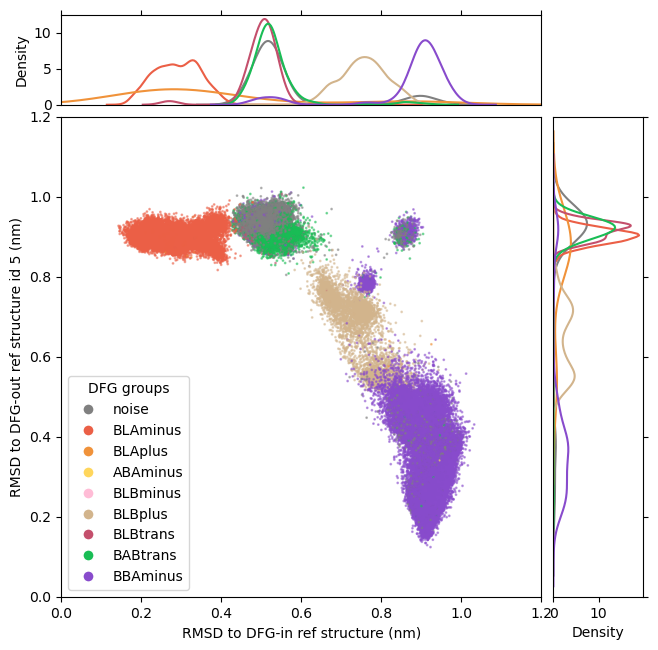

In [33]:
from matplotlib.lines import Line2D

dfg_out_rep_id = 5
rmsd_x = rmsds[0] # RMSD to DFG-in
rmsd_y = rmsds[dfg_out_rep_id] # RMSD to DFG-out

dihed_colors = np.array([
    (128/255, 128/255, 128/255),   # Gray
    (235/255, 95/255, 70/255),     # Light Red
    (240/255, 146/255, 58/255),    # Flamebright
    (255/255, 214/255, 92/255),    # Light yellow
    (255/255, 188/255, 214/255),   # Light pink
    (210/255, 180/255, 140/255),   # Tan
    (196/255, 79/255, 108/255),    # Strawberry
    (25/255, 189/255, 85/255),     # Light Green
    (136/255, 75/255, 204/255)])   # Light Purple

fig = plt.figure(figsize=(6,6))

scatter_ax = fig.add_axes([0, 0, 0.8, 0.8])
hist_top_ax =  fig.add_axes([0, 0.82, 0.8, 0.15])
hist_right_ax = fig.add_axes([0.82, 0, 0.15, 0.8])

scatter_ax.scatter(rmsd_x[::100], rmsd_y[::100], c=dihed_colors[dihedgroup[::100]+1], s=1, alpha=0.5)
scatter_ax.set_xlabel('RMSD to DFG-in ref structure (nm)')
scatter_ax.set_ylabel(f'RMSD to DFG-out ref structure id {dfg_out_rep_id} (nm)')
scatter_ax.set_xlim(0, 1.2)
scatter_ax.set_ylim(0, 1.2)

dihed_cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=dihed_colors[i], 
           markersize=8, label=f'{dihed_cluster_labels[i]}')
    for i in range(9)
]
scatter_ax.legend(handles=legend_elements, loc='lower left', title='DFG groups', frameon=True, fontsize=10)

for dihed_id in range(-1,8):
    sns.kdeplot(x=rmsd_x[dihedgroup == dihed_id][::1000], ax=hist_top_ax, color=dihed_colors[dihed_id+1])
    sns.kdeplot(y=rmsd_y[dihedgroup == dihed_id][::1000], ax=hist_right_ax, color=dihed_colors[dihed_id+1])

hist_right_ax.tick_params(axis='y', labelleft=False, labelright=False, left=False, right=True)
hist_right_ax.set_ylim(0, 1.2)
hist_top_ax.tick_params(axis='x', labelbottom=False, labeltop=False, bottom=False, top=True)
hist_top_ax.set_xlim(0, 1.2)

plt.savefig(save_dir / 'aloop_rmsd_vs_crystal_reps.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()